In [19]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, rmse, mape, smape
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

In [20]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2000-01-01,0.751094
1,AAPL,2000-01-08,0.758171
2,AAPL,2000-01-15,0.840263
3,AAPL,2000-01-22,0.767135
4,AAPL,2000-01-29,0.815259
...,...,...,...
8611,NVDA,2024-07-06,129.240005
8612,NVDA,2024-07-13,117.930000
8613,NVDA,2024-07-20,113.059998
8614,NVDA,2024-07-27,103.730003


In [21]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [22]:
season_length = 52 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [23]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_train_df, h=12) # forecast data
Y_hat_df.head(5) 

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-01,128.675323,128.575684,128.583466,128.754333
AAPL,2023-01-08,128.181381,128.590469,128.270798,128.839279
AAPL,2023-01-15,128.665451,128.605255,129.308975,128.845596
AAPL,2023-01-22,128.327347,128.620056,130.796860,129.579315
AAPL,2023-01-29,128.616730,128.634842,131.615341,129.745880


In [24]:
cv_df = sf.cross_validation(df=Y_train_df, h=12, n_windows=3, step_size=12, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2022-04-30,2022-04-23,155.292297,156.185471,151.803558,160.567383,156.011398,135.020157,177.002625,153.637909,149.775116,157.579300,157.465302,151.062500,163.722855
AAPL,2022-05-07,2022-04-23,145.464264,156.985443,150.843628,163.127274,156.364670,126.567551,186.161789,154.105728,148.380936,160.389771,157.879944,151.665253,164.054474
AAPL,2022-05-14,2022-04-23,136.050751,157.752396,150.162155,165.342651,156.717941,120.086548,193.349335,153.498703,146.547684,160.557541,158.470062,152.197021,164.879578
AAPL,2022-05-21,2022-04-23,147.965973,158.945007,149.909454,167.980545,157.071213,114.613403,199.529037,151.735123,143.113770,160.884766,158.823242,152.544113,165.242126
AAPL,2022-05-28,2022-04-23,143.753632,159.735611,149.645279,169.825943,157.424500,109.776276,205.072708,152.807632,143.069870,161.145370,159.688095,153.188232,165.961151


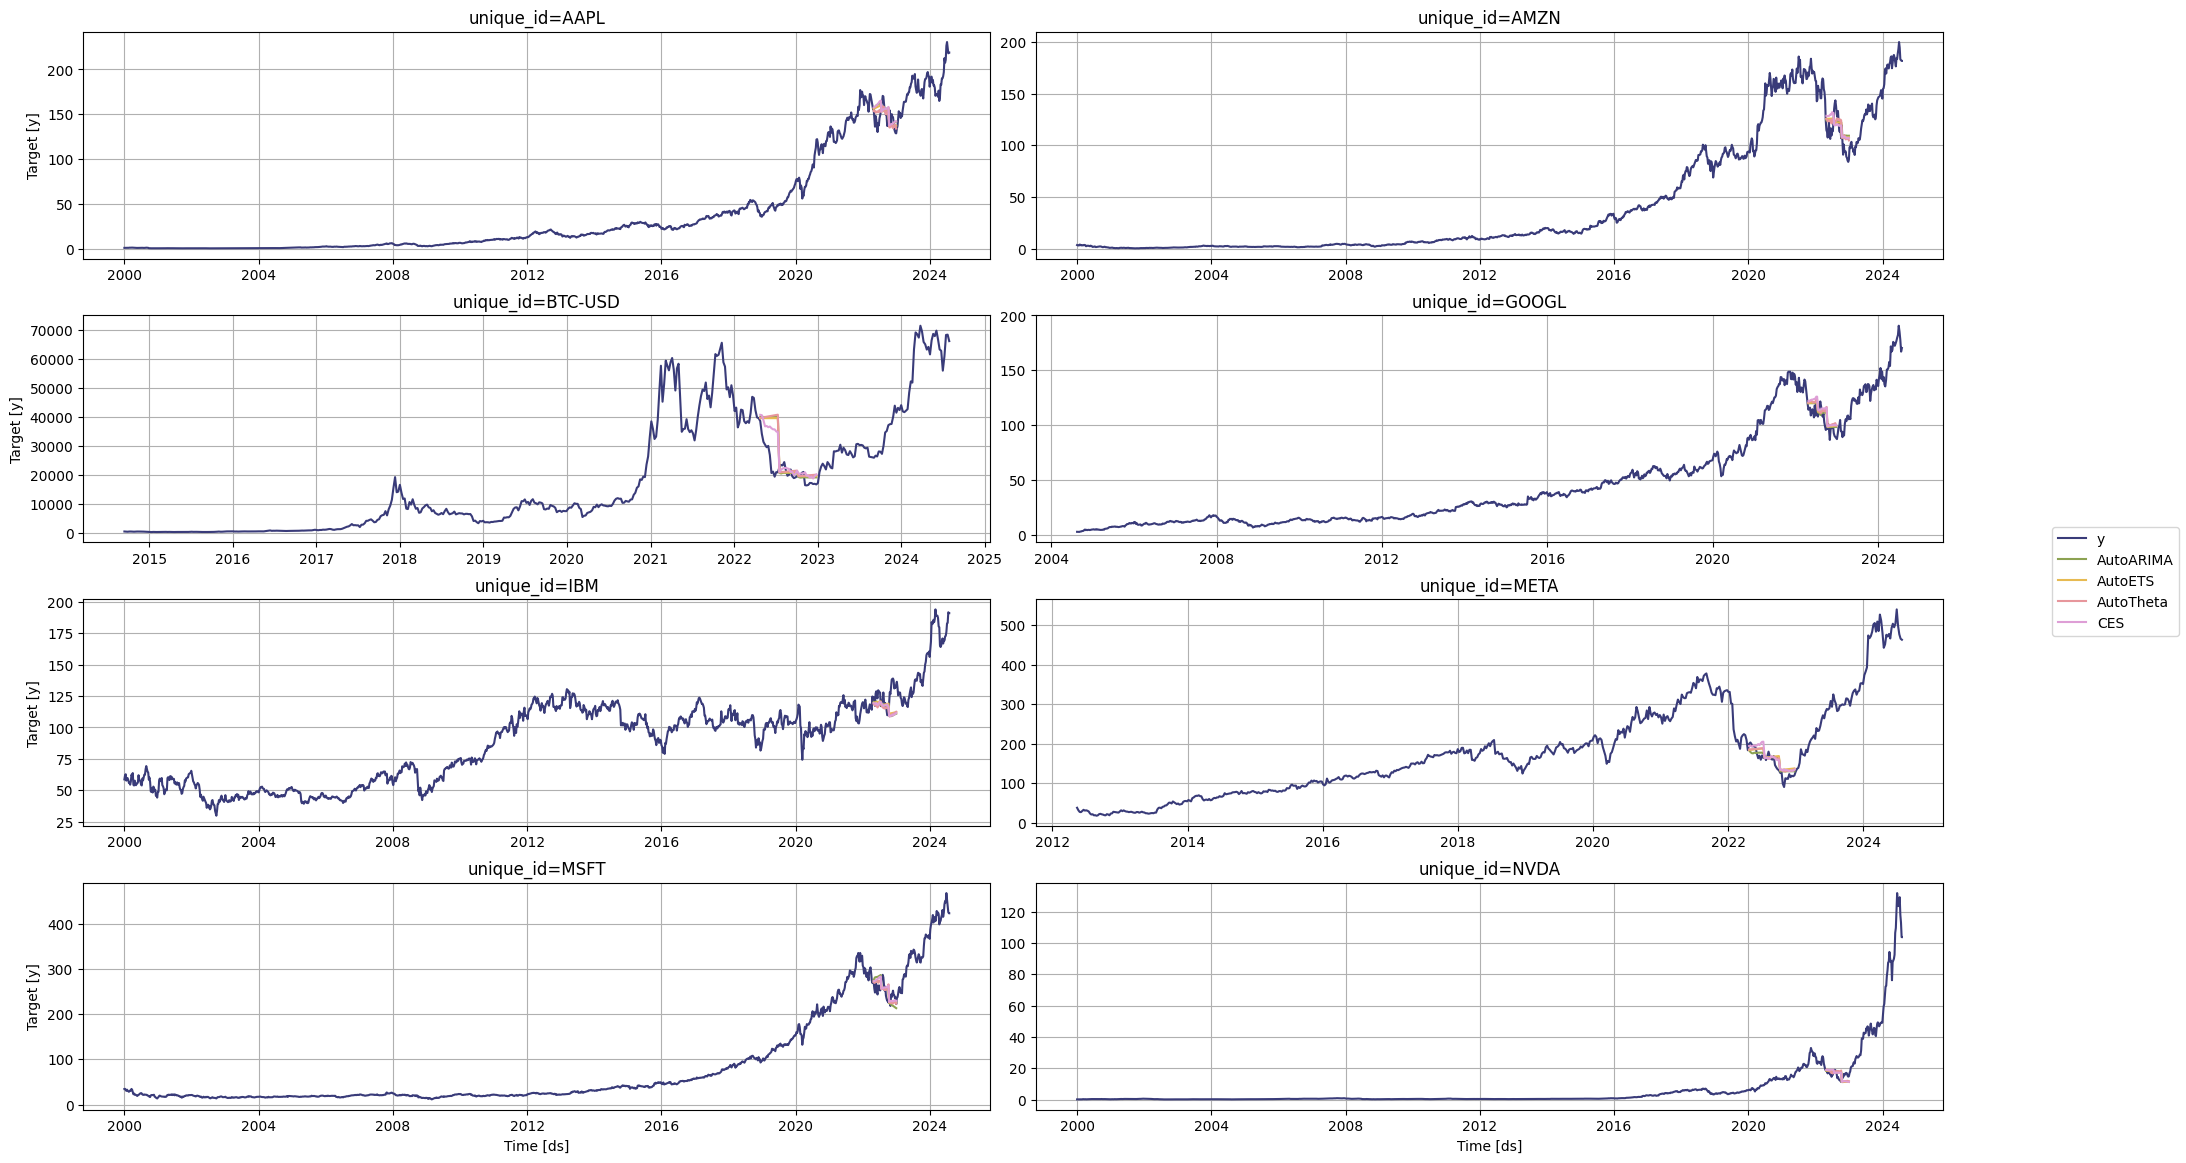

In [25]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))